In [1]:
import os
import json
from multiprocessing import Pool
from datetime import datetime
import pandas as pd

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import itertools

In [2]:
data_folder = "./output"
output_folder = "./frames"
geo_shapes_folder = "./geodata"

os.makedirs(output_folder, exist_ok=True)

In [3]:

#fnames = [os.path.join(root, f) for root, _, files in os.walk(geo_shapes_folder) for f in files if f.endswith(())]
#local_data = [list(shpreader.Reader(shape_file).geometries()) for shape_file in fnames]
geo_resources = [
    (
        shpreader.natural_earth(resolution = "10m", category='cultural', name="urban_areas"),
        {"edgecolor": 'none', "facecolor": "gray", 'alpha': 1, 'zorder': 0}
    ),
    (
        shpreader.natural_earth(resolution = "10m", category='cultural', name="admin_1_states_provinces"),
        {"edgecolor": 'black', "facecolor": "lightgrey", 'alpha': 0.8, 'zorder': 1}
    ),
]

data = [(shpreader.Reader(resource).geometries(), styling) for resource, styling in geo_resources]
cities = [city for city in shpreader.Reader(shpreader.natural_earth(resolution = "10m", category='cultural', name="populated_places")).records() if city.attributes.get('TIMEZONE') and city.attributes['TIMEZONE'].startswith('Europe')]
roads = list(shpreader.Reader(shpreader.natural_earth(resolution = "10m", category='cultural', name="roads")).geometries())
print(cities[56])

Record(POINT (26.3829966 46.9400041), {'SCALERANK': 10, 'NATSCALE': 1, 'LABELRANK': 6, 'FEATURECLA': 'Admin-1 capital', 'NAME': 'Piatra-Neamt', 'NAMEPAR': None, 'NAMEALT': None, 'NAMEASCII': 'Piatra-Neamt', 'ADM0CAP': 0, 'CAPIN': None, 'WORLDCITY': 0, 'MEGACITY': 0, 'SOV0NAME': 'Romania', 'SOV_A3': 'ROU', 'ADM0NAME': 'Romania', 'ADM0_A3': 'ROU', 'ADM1NAME': 'Neamt', 'ISO_A2': 'RO', 'NOTE': None, 'LATITUDE': 46.940004, 'LONGITUDE': 26.382997, 'POP_MAX': 102688, 'POP_MIN': 102688, 'POP_OTHER': 0, 'RANK_MAX': 9, 'RANK_MIN': 9, 'MEGANAME': None, 'LS_NAME': None, 'MAX_POP10': 0, 'MAX_POP20': 0, 'MAX_POP50': 0, 'MAX_POP300': 0, 'MAX_POP310': 0, 'MAX_NATSCA': 0, 'MIN_AREAKM': 0, 'MAX_AREAKM': 0, 'MIN_AREAMI': 0, 'MAX_AREAMI': 0, 'MIN_PERKM': 0, 'MAX_PERKM': 0, 'MIN_PERMI': 0, 'MAX_PERMI': 0, 'MIN_BBXMIN': 0.0, 'MAX_BBXMIN': 0.0, 'MIN_BBXMAX': 0.0, 'MAX_BBXMAX': 0.0, 'MIN_BBYMIN': 0.0, 'MAX_BBYMIN': 0.0, 'MIN_BBYMAX': 0.0, 'MAX_BBYMAX': 0.0, 'MEAN_BBXC': 0.0, 'MEAN_BBYC': 0.0, 'TIMEZONE': 'Eur

In [4]:

def render_frame(input_filepath: str, output_filepath: str):
    with open(input_filepath, "r", encoding="utf-8-sig") as infile:
        vehicles_json = json.load(infile)

    vehicles = vehicles_json["Vehicles"]
    vehicles_df = pd.DataFrame(vehicles)
    active_vehicles_df = vehicles_df[vehicles_df.IsInactive==False]

    timestamp_string_formatted = vehicles_json["LastUpdate"][:-14]
    timestamp = datetime.strptime(timestamp_string_formatted, "%Y-%m-%dT%H:%M:%S")
    
    fig = plt.figure(figsize=(16,9), facecolor='white', tight_layout=True)
    ax = plt.subplot(projection=ccrs.PlateCarree())
    plt.title('Aktivní vozidla MHD IDSJMK', loc='left')
    plt.title(timestamp.strftime("%Y-%m-%d %H:%M:%S"), loc='right')
    plt.tight_layout()

    # render background
    for geometry, styling in data:
        ax.add_geometries(geometry, ccrs.PlateCarree(), **styling)

    # render cities
    for city in cities:
        pos = city.geometry
        ax.scatter(pos.x, pos.y, c="black", s=max(city.attributes['SCALERANK']*2 or 10, 10), alpha=1, zorder=3, marker='s')
        ax.annotate(city.attributes['NAME'], (pos.x+0.03, pos.y+0.03), zorder=5)


    # render vehicles
    ax.scatter(active_vehicles_df['Lng'], active_vehicles_df['Lat'], c="blue", s=5, alpha=1, zorder=4)
    lat_min = vehicles_df['Lat'].min()
    lat_max = vehicles_df['Lat'].max()
    lng_min = vehicles_df['Lng'].min()
    lng_max = vehicles_df['Lng'].max()

    ax.set_extent([lng_min, lng_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    plt.savefig(output_filepath, dpi=600)

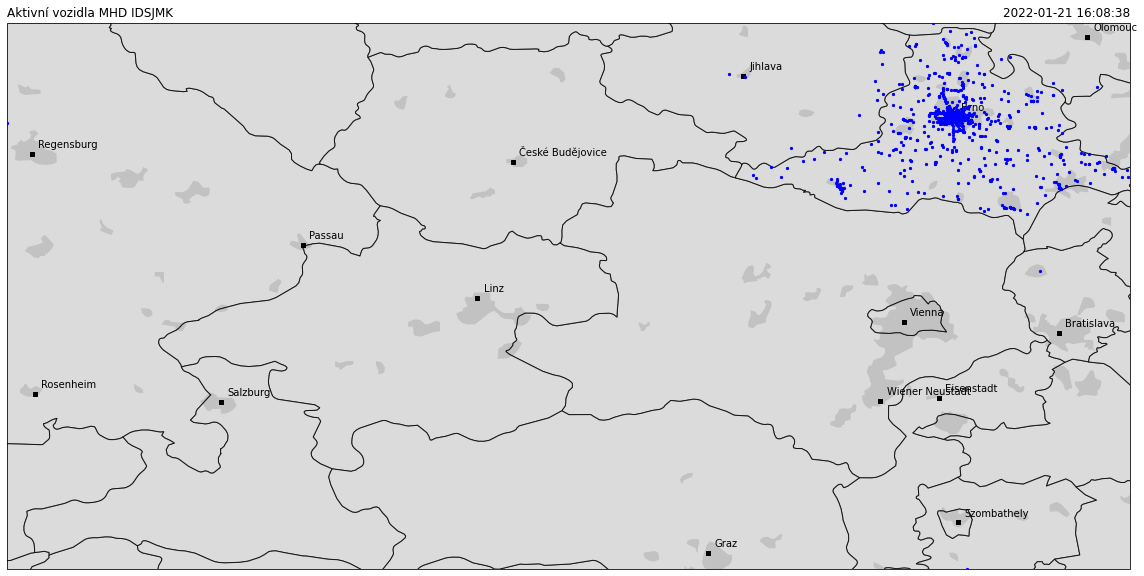

In [5]:
input_filepaths = [os.path.join(data_folder,f) for f in os.listdir(data_folder) if os.path.isfile(os.path.join(data_folder, f))]
params = [(infile, os.path.join(output_folder,f"{i}.png")) for i, infile in enumerate(input_filepaths)]

render_frame(params[0][0], params[0][1])

#with Pool() as p:
#    p.starmap(render_frame, params)
